In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import json
import os
import time
import nltk
nltk.download('punkt')

from bertopic import BERTopic
from bertopic.representation import BaseRepresentation
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

import google.generativeai as genai
from dotenv import load_dotenv

csv_path = '/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/innerspeech_translated_batched_API.csv'
df = pd.read_csv(csv_path)


reports = df['reflection_answer_english'].dropna().astype(str).tolist()
print(f"Loaded {len(reports)} (translated) documents for BERTopic modeling.")

# ----------------------------------------

# ----------------------------------------
# Divide each report into sentences
# Add additional safety check to ensure no None/NaN values slip through
reports_sentences = []
for report in reports:
    if pd.notna(report) and isinstance(report, str) and report.strip():
        sentences = nltk.sent_tokenize(report)
        reports_sentences.append(sentences)
    else:
        print(f"Skipping invalid report: {report}")

sentences = [sentence for report in reports_sentences for sentence in report]
print(f"Total number of sentences across all reports: {len(sentences)}")
# ----------------------------------------

# This is the most efficient and readable way to filter sentences by length.
min_word_count = 2
sentences = [s for s in sentences if len(s.split()) >= min_word_count]
print(f"Total number of sentences after filtering by length: {len(sentences)}")

docs = sentences
# # ----------------------------------------
# # Divide each report into sentences
# reports_sentences = [nltk.sent_tokenize(report) for report in reports]

# sentences = [sentence for report in reports_sentences for sentence in report]
# print(f"Total number of sentences across all reports: {len(sentences)}")
# # ----------------------------------------

# # This is the most efficient and readable way to filter sentences by length.
# min_word_count = 2
# sentences = [s for s in sentences if len(s.split()) >= min_word_count]
# print(f"Total number of sentences after filtering by length: {len(sentences)}")

# docs = sentences

Loaded 730 (translated) documents for BERTopic modeling.
Total number of sentences across all reports: 1913
Total number of sentences after filtering by length: 1899


[nltk_data] Downloading package punkt to /Users/rbeaute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
for i, report in enumerate(reports[:10]):
    print(f"Report {i+1}:\n{report}\n{'-'*80}")

Report 1:
This survey made me realize my inner monologue, and it was interesting to learn about the various patterns.
--------------------------------------------------------------------------------
Report 2:
I'm very interested in the idea that some people hear voices in their heads that are not their own.  Do you think it's possible to materialize the voices in someone's head through psychophysical experiments by repeatedly tuning the parameters of the audio or conducting A/B tests? (Although, I wonder if trying to materialize it might make it elusive, like grasping at mist.)
--------------------------------------------------------------------------------
Report 3:
I am aware that I think in Japanese (I hardly ever use English except for studying), but when asked if it's text or audio, it feels like a mix of both.  Sometimes images or tastes are recalled.
--------------------------------------------------------------------------------
Report 4:
I think it's automatic thinking, but ne

In [23]:
# To print sentences that were removed during filtering by length:
original_sentences = [sentence for report in reports_sentences for sentence in report]
removed_sentences = [s for s in original_sentences if len(s.split()) < min_word_count]
for s in removed_sentences:
    print(s)

).
Sorry...
ADHD/ASD.
1.
2.
3.
).
appears.
Wait?
form.
haha
).
Penis
).


In [24]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import datamapplot  # For data visualization
import re  # For regular expressions

In [25]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)


# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, 
            n_gpu_layers=-1, #offload all possible layers of the model to the GPU
            n_ctx=4096, 
            stop=["Q:", "\n"],
            verbose=False)

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

In [31]:
prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]


The topic is described by the following keywords: '[KEYWORDS]'.


This is a dataset about different types of innerspeech. Based on the above information, can you give a short, informative label of the topic of at most 5-10 words?
A:
"""


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en-v1.5")
embeddings = embedding_model.encode(docs, show_progress_bar=True)


# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=None)




# Define sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=40, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [32]:
topic_model = BERTopic(
 # Sub-models
 embedding_model=embedding_model,
 umap_model=umap_model,
 hdbscan_model=hdbscan_model,
 representation_model=representation_model,
 vectorizer_model=vectorizer,
 nr_topics="auto",  # Automatically determine the number of topics

 # Hyperparameters
 top_n_words=10,
 verbose=True
)


# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)


# Show topics
topic_model.get_topic_info()

2025-06-25 13:44:32,710 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-25 13:44:36,882 - BERTopic - Dimensionality - Completed ✓
2025-06-25 13:44:36,883 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-25 13:44:36,935 - BERTopic - Cluster - Completed ✓
2025-06-25 13:44:36,936 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-25 13:44:37,036 - BERTopic - Representation - Completed ✓
2025-06-25 13:44:37,037 - BERTopic - Topic reduction - Reducing number of topics
2025-06-25 13:44:37,040 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
2025-06-25 13:44:48,619 - BERTopic - Representation - Completed ✓
2025-06-25 13:44:48,620 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,804,-1_the_my_it_in,"[the, my, it, in, and, to, of, when, or, that]","[in my head, thinking, my inner speech, though...","[""Inner Speech and Thought Processes"", , , , ,...",[When I'm thinking about what to eat in everyd...
1,0,654,0_inner_my_speech_inner speech,"[inner, my, speech, inner speech, the, in, to,...","[my inner speech, inner speech is, inner speec...","[""Characteristics of Inner Speech and Self-Ref...",[My inner speech is always talking to me in my...
2,1,230,1_images_in_the_and,"[images, in, the, and, my, when, it, like, to,...","[my thoughts, thoughts, thinking, when thinkin...","[""Inner Speech and Visual Imagery Processes"", ...","[Before taking it, I felt like thoughts and vi..."
3,2,159,2_this_interesting_the_was,"[this, interesting, the, was, it, research, re...","[this interesting, it was interesting, very in...","[""Research on Inner Speech and Its Results"", ,...","[This is very interesting., This was very inte..."
4,3,52,3_it_my_thinking_to,"[it, my, thinking, to, thoughts, the, think, a...","[thinking but, find it difficult, thinking, th...","[""Subjective Experience of Inner Speech and Th...",[When I'm thinking without using words one by ...


In [33]:
topic_model.visualize_documents(docs, 
                                reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, 
                                hide_document_hover=False, 
                                custom_labels=True)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `llama-3-8b-instruct`'}>)

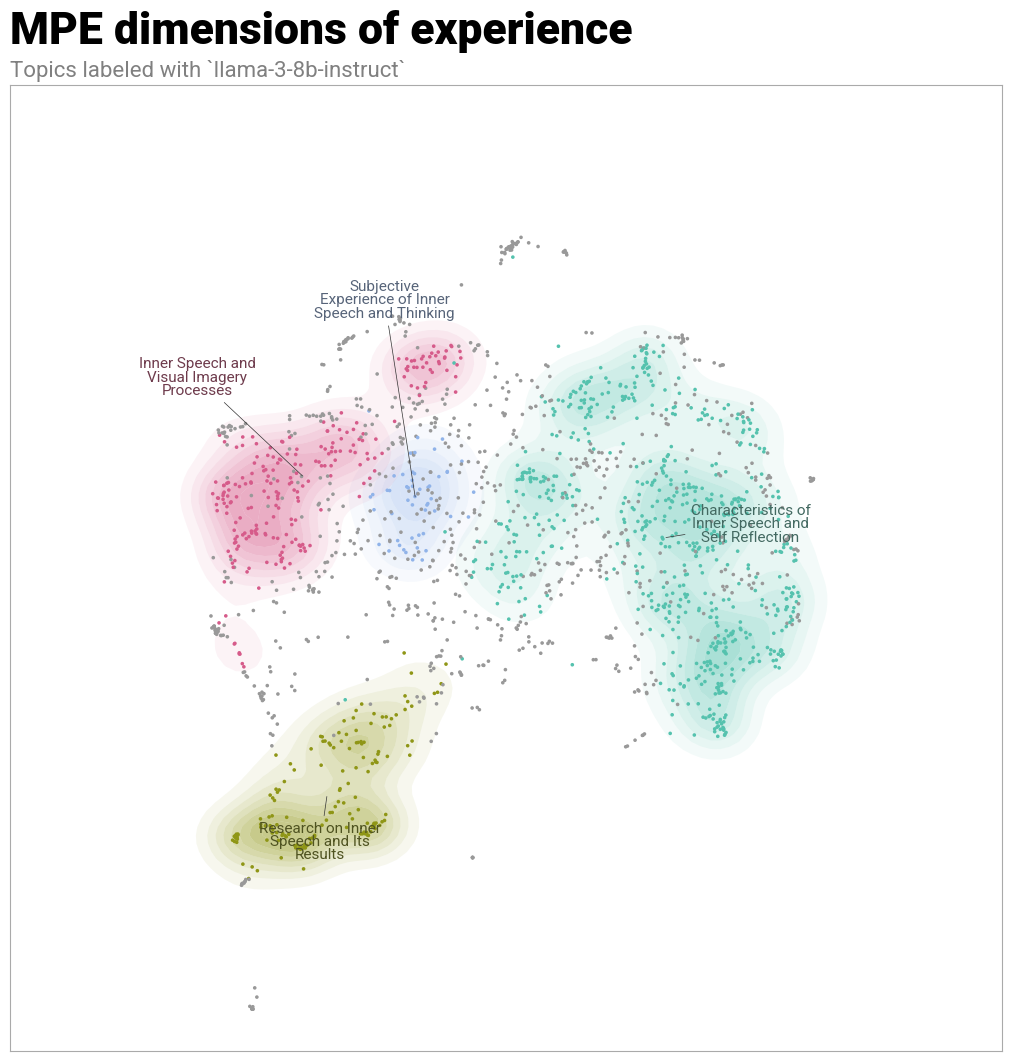

In [ ]:
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]


# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title="Innerspeech dimensions of experience",
   sub_title="Topics labeled with `llama-3-8b-instruct`",
   label_wrap_width=20
)